> Importing Libraries

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.metrics import accuracy_score
from collections import Counter
import random
import pickle
path_train = "/kaggle/input/dataset/train.json"
path_test = "/kaggle/input/dataset/test.json"

Data Reading

In [56]:
data = pd.read_json(path_train)
data.head()
cuisines = data['cuisine'].unique().tolist()
cuisines_to_index = {cuisine: index for index, cuisine in enumerate(cuisines)}
index_to_cuisine = {index: cuisine for cuisine, index in cuisines_to_index.items()}

Data Distribution over Different Cuisines

Text(0.5, 1.0, 'Cuisine Distribution')

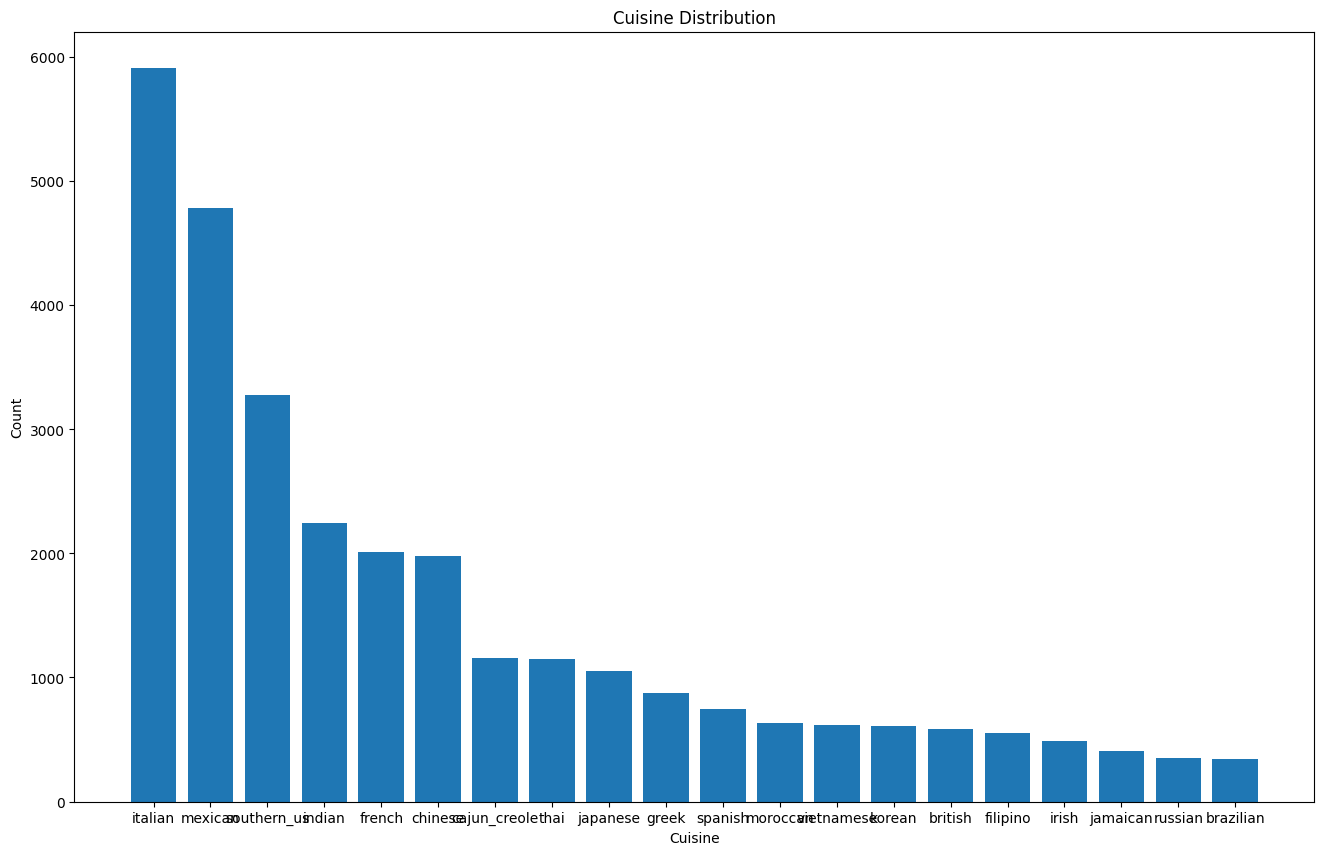

In [57]:
cuisine_counts = data['cuisine'].value_counts()
plt.figure(figsize=(16, 10))
plt.bar(cuisine_counts.index, cuisine_counts.values)
plt.xlabel('Cuisine')
plt.ylabel('Count')
plt.title('Cuisine Distribution')

Data Augmentation

In [58]:
cuisine_counts = data['cuisine'].value_counts()
threshold = 1800
minority_cuisines = cuisine_counts[cuisine_counts < threshold].index.tolist()

def get_specific_ingredients(data, cuisine, min_freq=5, max_other_freq=2):
    ingredients_in_cuisine = data[data['cuisine'] == cuisine]['ingredients']
    all_ingredients = [item for sublist in ingredients_in_cuisine for item in sublist]
    ingredient_counts = Counter(all_ingredients)
    
    other_cuisines = data[data['cuisine'] != cuisine]['ingredients']
    all_other_ingredients = [item for sublist in other_cuisines for item in sublist]
    other_counts = Counter(all_other_ingredients)
    
    specific_ingredients = [
        ingredient for ingredient, count in ingredient_counts.items()
        if count >= min_freq and other_counts[ingredient] <= max_other_freq
    ]
    return specific_ingredients

specific_ingredients_by_cuisine = {
    cuisine: get_specific_ingredients(data, cuisine)
    for cuisine in minority_cuisines
}

def generate_synthetic_recipe(cuisine, specific_ingredients, num_ingredients=5):
    return random.sample(specific_ingredients, min(num_ingredients, len(specific_ingredients)))

synthetic_data = []
new_id = max(data['id']) + 1

for cuisine in minority_cuisines:
    specific_ingredients = specific_ingredients_by_cuisine[cuisine]
    num_synthetic_samples = threshold - cuisine_counts[cuisine]  # Balance the class
    for _ in range(num_synthetic_samples):
        synthetic_recipe = generate_synthetic_recipe(cuisine, specific_ingredients)
        synthetic_data.append({
            "id": new_id,
            "cuisine": cuisine,
            "ingredients": synthetic_recipe
        })
        new_id += 1

synthetic_data_df = pd.DataFrame(synthetic_data)
augmented_data = pd.concat([data, synthetic_data_df], ignore_index=True)
data = augmented_data

Making Dictionaries and Visualising Gradients

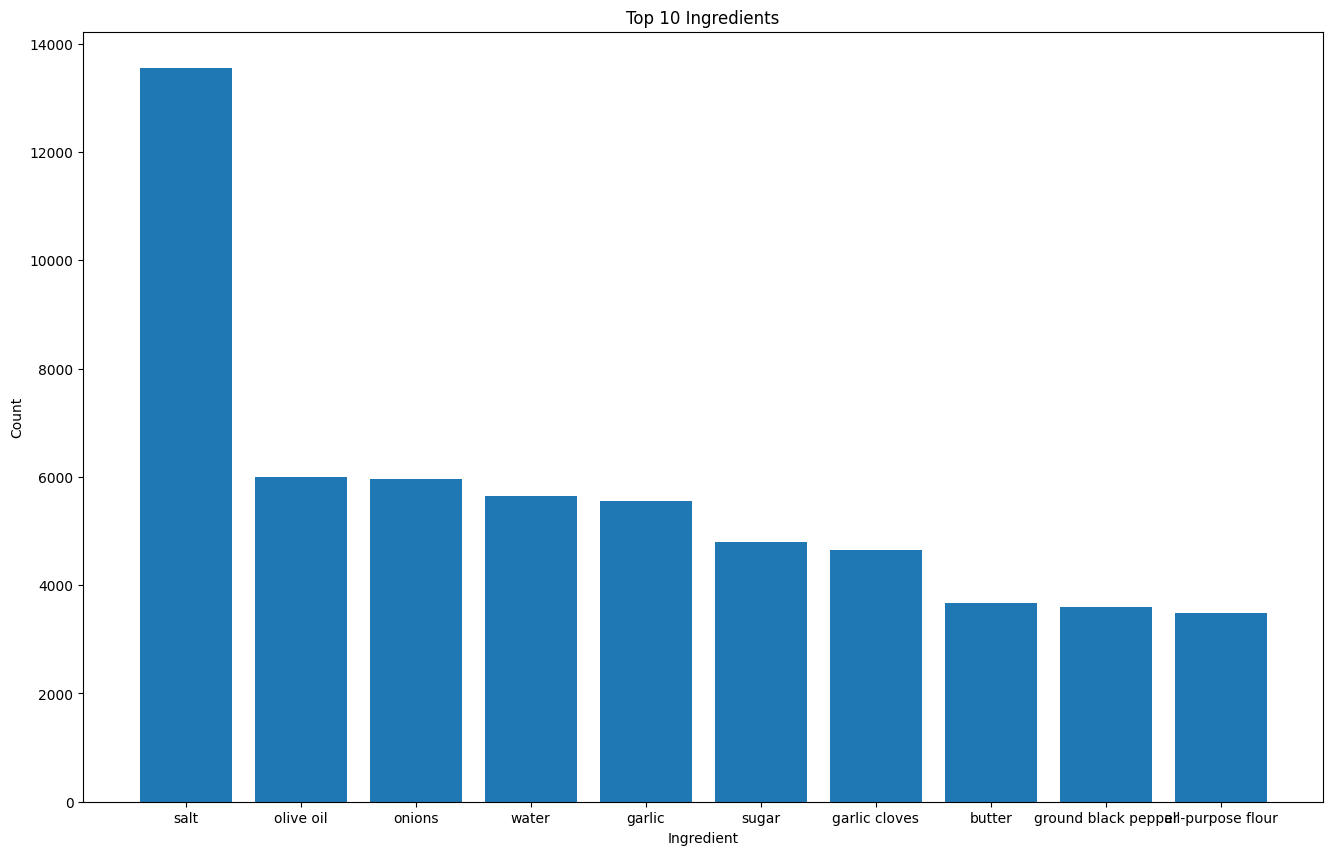

In [59]:
def topk_ingredients(ingredients, k):
    ingredient_count = pd.Series(ingredients).value_counts()
    top_k_ingredients = ingredient_count.head(k)
    return top_k_ingredients

ingredients = []
for recipe in data['ingredients']:
  for ingredient in recipe:
    ingredients.append(ingredient)
ingredients = np.array(ingredients)

top_k_ingredients = topk_ingredients(ingredients, 10)
plt.figure(figsize=(16, 10))
plt.bar(top_k_ingredients.index, top_k_ingredients.values)
plt.xlabel('Ingredient')
plt.ylabel('Count')
plt.title('Top 10 Ingredients')

ingredients = np.unique(ingredients).tolist()

Using TF-IDF for encoding Data

In [60]:
vectorizer = TfidfVectorizer(vocabulary = ingredients, lowercase = False)
tf_idf_df = vectorizer.fit_transform(data['ingredients'].apply(lambda x: ' '.join(x)))
X = pd.DataFrame(tf_idf_df.toarray(), columns=vectorizer.get_feature_names_out())
X['cuisine'] = data['cuisine']
X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)
X_train.head()

,( oz.) tomato sauce,( oz.) tomato paste,(10 oz.) frozen chopped spinach,"(10 oz.) frozen chopped spinach, thawed and squeezed dry",(14 oz.) sweetened condensed milk,(15 oz.) refried beans,1% low-fat buttermilk,1% low-fat chocolate milk,1% low-fat cottage cheese,1% low-fat milk,...,yuzu,yuzu juice,za'atar,zest,zesty italian dressing,zinfandel,ziti,zucchini,zucchini blossoms,cuisine
24720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.318652,0.0,indian
27520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,indian
38014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,british
45112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,brazilian
31173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,japanese


Feed Forward Neural Networks

In [61]:
#2 linear layers with activations LeakyRelU and lastly a softmax layer for probabilities calculation
class FNN(nn.Module):
  def __init__(self, input_dim, hidden_dim, hidden_dim2, num_classes):
    super(FNN, self).__init__()
    self.linear = nn.Linear(input_dim, hidden_dim)
    self.linear2 = nn.Linear(hidden_dim, hidden_dim2)
    self.bn1 = nn.BatchNorm1d(hidden_dim)
    self.bn2 = nn.BatchNorm1d(hidden_dim2)
    self.relu = nn.LeakyReLU()
    self.output = nn.Linear(hidden_dim2, num_classes)

  def forward(self, x):
    out = self.linear(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.linear2(out)
    out = self.bn2(out)
    out = self.relu(out)
    out = self.output(out)
    return out

Choosing Loss, Optimizer and Training the Neural Net

In [62]:
X_train['cuisine_idx'] = X_train['cuisine'].map(cuisines_to_index)
X_val['cuisine_idx'] = X_val['cuisine'].map(cuisines_to_index)

X_train_tensors = torch.tensor(X_train.iloc[:, :-2].values, dtype=torch.float32)
y_train_tensors = torch.tensor(X_train['cuisine_idx'].values, dtype=torch.long)
X_val_tensors = torch.tensor(X_val.iloc[:, :-2].values, dtype=torch.float32)
y_val_tensors = torch.tensor(X_val['cuisine_idx'].values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensors, y_train_tensors)
val_dataset = TensorDataset(X_val_tensors, y_val_tensors)
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = FNN(len(ingredients), 64, 32, len(cuisines))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 20

for epoch in range(epochs):
    model.train()
    train_losses = []
    train_labels = []
    train_preds = []

    for recipe_vectors, labels in train_loader:
        optimizer.zero_grad()
        output = model(recipe_vectors)
        loss = criterion(output, labels)
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        preds = output.argmax(dim=1)
        train_preds.extend(preds.tolist())
        train_labels.extend(labels.tolist())

    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for recipe_vectors, labels in val_loader:
            output = model(recipe_vectors)
            preds = output.argmax(dim=1)
            val_preds.extend(preds.tolist())
            val_labels.extend(labels.tolist())

    avg_train_loss = np.mean(train_losses)
    train_acc = accuracy_score(train_labels, train_preds)
    val_acc = accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch+1}, Loss: {avg_train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val Acc: {val_acc*100:.2f}%")

Epoch 1, Loss: 0.7924, Train Acc: 77.10%, Val Acc: 80.74%
Epoch 2, Loss: 0.6043, Train Acc: 81.81%, Val Acc: 81.64%
Epoch 3, Loss: 0.5441, Train Acc: 83.67%, Val Acc: 81.71%
Epoch 4, Loss: 0.5014, Train Acc: 84.92%, Val Acc: 81.90%
Epoch 5, Loss: 0.4685, Train Acc: 85.60%, Val Acc: 81.70%
Epoch 6, Loss: 0.4357, Train Acc: 86.33%, Val Acc: 81.50%
Epoch 7, Loss: 0.4132, Train Acc: 86.98%, Val Acc: 82.24%
Epoch 8, Loss: 0.3891, Train Acc: 87.48%, Val Acc: 81.91%
Epoch 9, Loss: 0.3728, Train Acc: 88.21%, Val Acc: 81.63%
Epoch 10, Loss: 0.3526, Train Acc: 88.85%, Val Acc: 81.66%
Epoch 11, Loss: 0.3360, Train Acc: 89.26%, Val Acc: 81.47%
Epoch 12, Loss: 0.3211, Train Acc: 89.69%, Val Acc: 81.43%
Epoch 13, Loss: 0.3140, Train Acc: 89.84%, Val Acc: 81.71%
Epoch 14, Loss: 0.3000, Train Acc: 90.39%, Val Acc: 81.27%
Epoch 15, Loss: 0.2929, Train Acc: 90.64%, Val Acc: 81.22%
Epoch 16, Loss: 0.2824, Train Acc: 90.83%, Val Acc: 81.25%
Epoch 17, Loss: 0.2750, Train Acc: 91.13%, Val Acc: 81.39%
Epoch 

Test Dataset

In [69]:
test_data = pd.read_json(path_test)
test_ids = test_data['id']

def preprocess_ingredients(ingredients_list):
    return [" ".join(ingredients) for ingredients in ingredients_list]

test_ingredients = preprocess_ingredients(test_data['ingredients'])

X_test_tfidf = vectorizer.transform(test_ingredients)
X_test_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)

model.eval()

with torch.no_grad():
    outputs = model(X_test_tensor)
    predictions = torch.argmax(outputs, dim=1).tolist()

predicted_cuisines = [index_to_cuisine[idx] for idx in predictions]

submission = pd.DataFrame({
    "id": test_ids,
    "cuisine": predicted_cuisines
})
submission.to_csv("/kaggle/working/submission.csv", index=False)

print("Predictions saved to submission.csv")


Predictions saved to submission.csv
